In [1]:
import requests
from os import listdir
import urllib.request
import json
import glob
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import pylab as pl
import numpy as np
import pandas as pd
from ast import literal_eval
# from interruptingcow import timeout
from collections import Counter


# import cv2
import skimage
from PIL import Image
from skimage.io import imread
from scipy.misc import imresize
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model, load_model
from keras.layers import *
from keras.utils import np_utils, to_categorical, Sequence
from keras import backend as K,objectives
from keras.losses import mse, binary_crossentropy
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam, RMSprop
from keras.initializers import RandomNormal
import random

import tensorflow as tf

# check the status of GPU
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

Using TensorFlow backend.


[]

In [2]:
def get_session():
    """Create a session that dynamically allocates memory."""
    # See: https://www.tensorflow.org/tutorials/using_gpu#allowing_gpu_memory_growth
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    session = tf.Session(config=config)
    return session

tf.reset_default_graph()
sess = get_session()

K.set_session(sess)

## 1.Data Preprocessing

The original PubFig data (http://www.cs.columbia.edu/CAVE/databases/pubfig/) contains 58,797 images for 200 people. For downloading, PubFig provides a $.txt$ file both for training (60 Fig) and evaluation, each contains:
- the person name,
- the image number for that person,
- the original image URL,
- the face rectangle around the person, as x0,y0,x1,y1 coordinates (x- and y-locations of the top-left and bottom-right corners of the face).

However, during our exploration, we find two problems:
- first, a certain number of the URL does not work anymore.
- second, some picture contains other people besides our chosen people; what's more, there is also lots of irrelevant information on the image.
- third, some of the images are repeated.

After careful discussion and consideration, we resolve the problems this way:
- we only work with the picture with valid URLs.
- we crop the picture according to the position information listed above and only keep the pixels of the chosen people's face. After cropping the images, we find that some of the images does not reflect the proper faces, and we remove then manually.
- we also remove the repeated images manually.





### 1.1 Scrape and Crop the data

In [3]:
count = 16338
# train_file = open('dev_urls.txt' ,'r')
# count = 0
# for idx,line in enumerate(train_file):
#     count += 1
#     if idx > 1:
#         words = str.split(line,'\t')
#         url_i = words[2]
#         facpos_i = words[3]
#         name_i = words[0].replace(' ','')
#         picname_i = words[0].replace(' ','')+words[1]
#         try:
#             with timeout(5, exception = RuntimeError): #limit to 5 seconds, otherwise might be stuck in some website
#                 try: 
#                     urllib.request.urlretrieve(url_i,'./original/{}.jpg'.format(picname_i))
#                     img = Image.open('original/{}.jpg'.format(picname_i))
#                     img = img.crop(literal_eval(facpos_i))
#                     img.save("./cleaned/{}.jpg".format(picname_i))
#                 except:
#                     pass
#         except RuntimeError:
#             pass
          

                      Abhishek Bachan


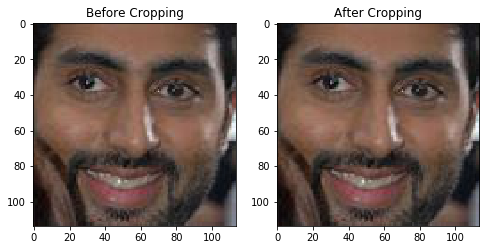

In [4]:
fig, ax = plt.subplots(1,2, figsize=(8,8)) 
img_before = plt.imread('cleaned/AbhishekBachan1.jpg')
img_after = plt.imread('cleaned/AbhishekBachan1.jpg')
print('                      Abhishek Bachan')
ax[0].imshow(img_before)
ax[0].set_title('Before Cropping')

ax[1].imshow(img_after)
ax[1].set_title('After Cropping');

### 1.2 Exploratory Data Analysis

In [5]:
images_path = glob.glob('cleaned/*.jpg')

print('Before data Cleaning, there are {} observations in the set'.format(count))
print('After data cleaning, there are {} observations in the set'.format(len(images_path)))

Before data Cleaning, there are 16338 observations in the set
After data cleaning, there are 6384 observations in the set


In [6]:
response_path = [path.split('/')[-1].split('.')[0].rstrip('0123456789') for path in images_path]

name_list = list(Counter(response_path).keys())
count_list = list(Counter(response_path).values())

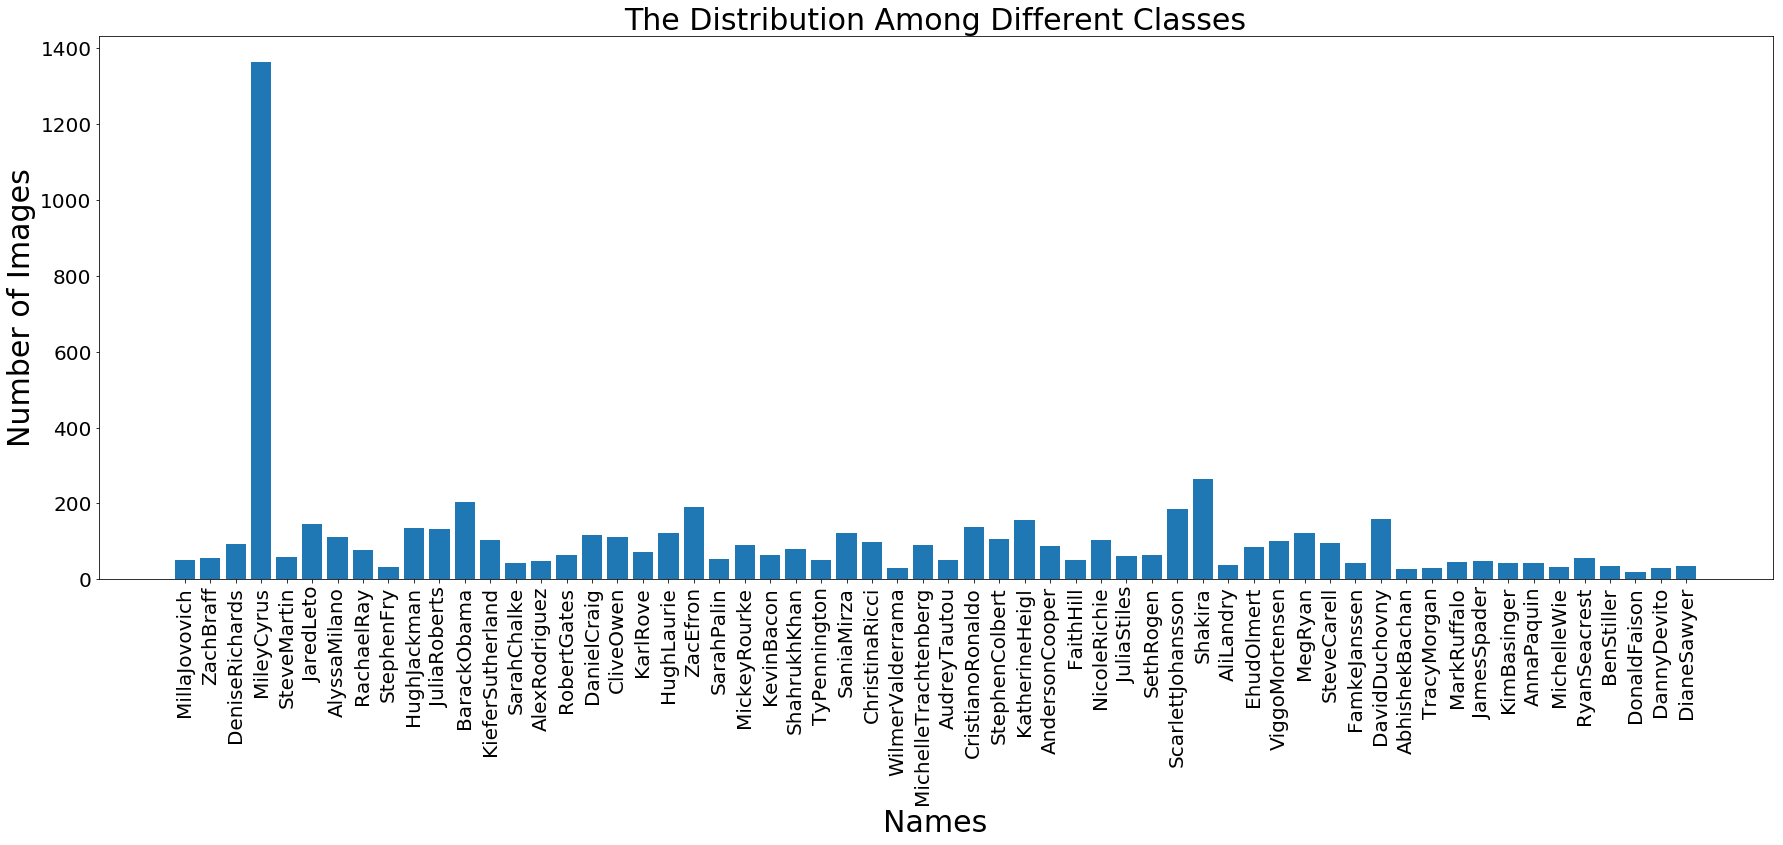

In [7]:
plt.figure(figsize = (30,10))
plt.bar(name_list, count_list)
plt.tick_params(labelsize=20)
pl.xticks(rotation=90)
plt.xlabel('Names',fontsize = 30)
plt.ylabel('Number of Images', fontsize = 30)
plt.title('The Distribution Among Different Classes',fontsize = 30);

From the plot above we can see that, there is a strong data imbalance, especially for MileyCyrus. 

### 1.3 Posing and Projecting Faces

After cropping the face images, we also want to enhance the face to be projected in the same way as faces turned different directions look totally different to the model. Here, we use the face landmark estimation algorithm depicted in this paper: http://www.csc.kth.se/~vahidk/papers/KazemiCVPR14.pdf.

In [8]:
# from imutils import face_utils
# from imutils.face_utils import FaceAligner

# # detector = dlib.get_frontal_face_detector()
# predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")
# fa = FaceAligner(predictor, desiredFaceWidth=64)

# for i in :
#     = fa.align(image)
# # Face Align Function
# def faceAlign(image):
#     #image = mpimg.imread(img)
#     image = imutils.resize(image, width=150)
#     gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

#     rects = detector(gray, 2)
#     faceAligned = []
#     for rect in rects:
#         faceAligned = fa.align(image, gray, rect)
        #print(rect)
        #plt.imshow(faceAligned)
    
#     return faceAligned

### 1.3 Sub-Sampling

To alleviate the imbalance as well as ensure sufficient training image for an individual class, we will only keep the classes with more than 100 images, also we will down-sample the class of MileyCryrus to 200.

In [9]:
count_threshold = 100

name_to_keep = np.array(name_list)[np.array(count_list)>count_threshold]
print('There will be {} classes left.'.format(np.sum(np.array(count_list)>count_threshold)))

There will be 21 classes left.


In [10]:
mask = []
for name_i in response_path:
    if name_i in name_to_keep:
        mask.append(True)
    else: mask.append(False)

image_path_sample = np.array(images_path)[mask]
response_path_sample = np.array(response_path)[mask]

print('There will be {} observations left.'.format(len(response_path_sample)))

There will be 4197 observations left.


In [11]:
index_mc = []
for index, value in enumerate(response_path_sample):
    if value == 'MileyCyrus':
        index_mc.append(index)

np.random.seed(2019)
index_mc_drop = np.random.choice(index_mc, len(index_mc)-250, replace = False)

mask_1 = np.ones(len(image_path_sample), dtype=bool)
mask_1[index_mc_drop] = False
image_path_sample = image_path_sample[mask_1]
response_path_sample = response_path_sample[mask_1]

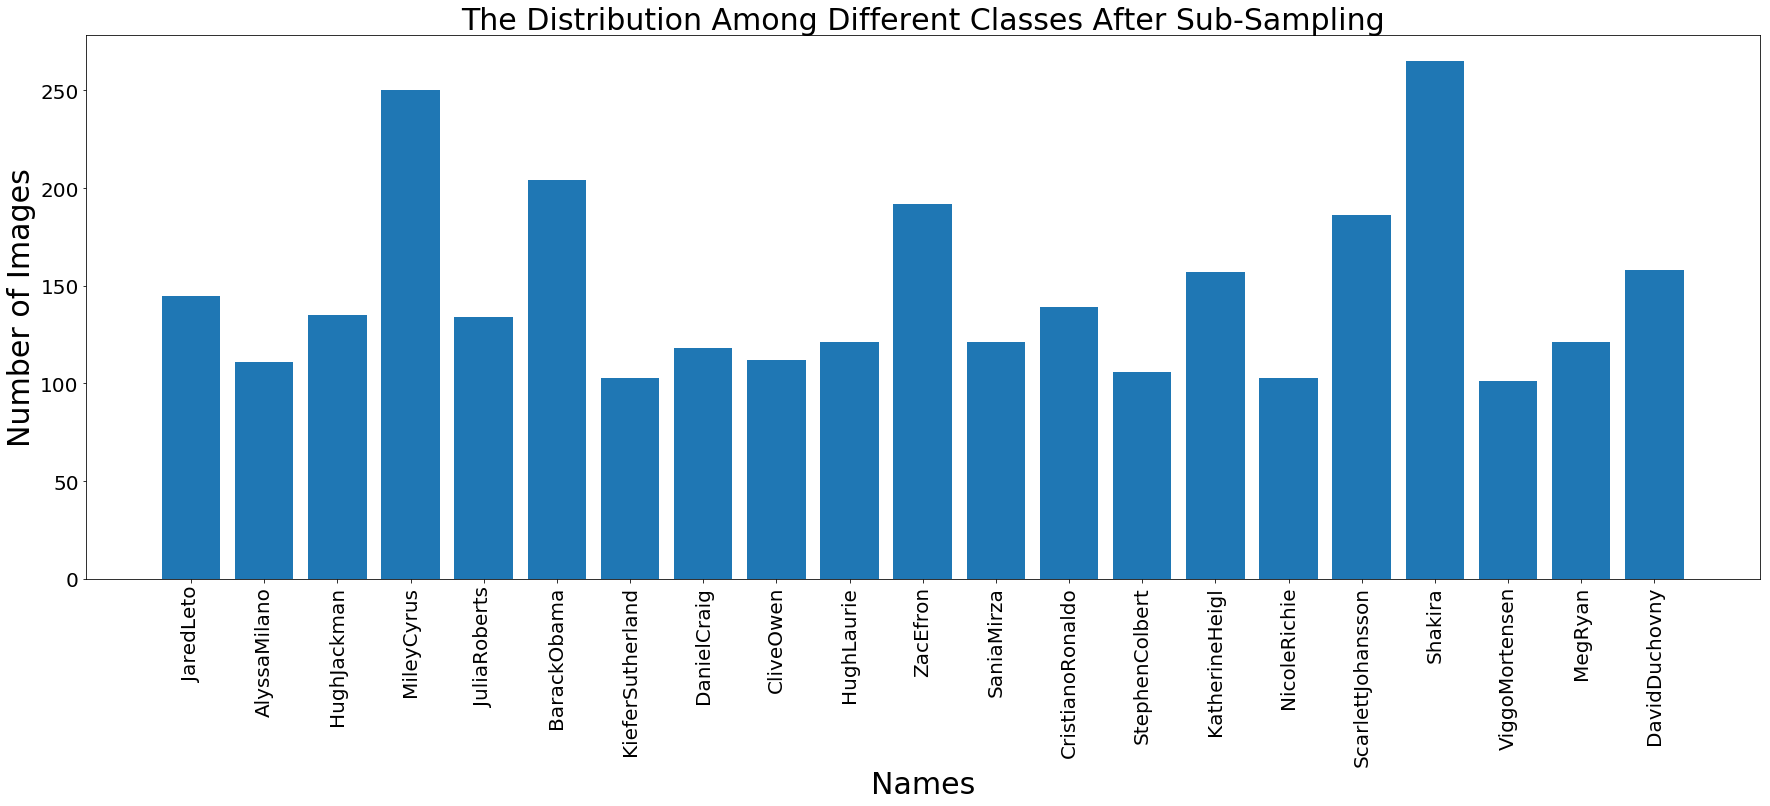

In [12]:
response_path_sample = [path.split('/')[-1].split('.')[0].rstrip('0123456789') for path in image_path_sample]

name_list_sample = list(Counter(response_path_sample).keys())
count_list_sample = list(Counter(response_path_sample).values())

plt.figure(figsize = (30,10))
plt.bar(name_list_sample, count_list_sample)
plt.tick_params(labelsize=20)
pl.xticks(rotation=90)
plt.xlabel('Names',fontsize = 30)
plt.ylabel('Number of Images', fontsize = 30)
plt.title('The Distribution Among Different Classes After Sub-Sampling',fontsize = 30);

From the plot we can see that the sample now is more balanced.

## 2. Model Preparation

### 2.1 Train, Test, Validation Split

In our case of training the CNN, we will do hyperparamter estimation from the 'Data-Driven' perspective, which is cross-validation.

Before feeding the data into our neural net, we split our data into train, test and validation set. To be specific, we will train and evaluate the model respectively on training set and validation set each epoch; At the end, we compare the performance of each model with its performance on test set. Also, we will keep tract of the history of the performance on training and validation set each epoch to see if there is a severe overfitting problem.

In [13]:
X_TRAIN_path, X_test_path, Y_TRAIN_path,  y_test_path = train_test_split(image_path_sample, response_path_sample, test_size = 0.05, random_state = 2019)
X_train_path, X_val_path, y_train_path,  y_val_path = train_test_split(X_TRAIN_path, Y_TRAIN_path, test_size = 0.1, random_state = 2019)

print('# Training Images: {}'.format(len(X_train_path)))
print('# Validation Images: {}'.format(len(X_val_path)))
print('# Test Images: {}'.format(len(X_test_path)))


# Training Images: 2634
# Validation Images: 293
# Test Images: 155


### 2.2 Processing features and response

We will resize the image to a uniform size; also, we will normalize the image to make the network converge faster. 

In [14]:
# Parameters
BATCH_SIZE = 16
HEIGHT = 64
WIDTH = 64

In [15]:
def X_processing(X_input):
    X_train = np.empty(shape = (len(X_input), HEIGHT, WIDTH, 3))
    for i, file in enumerate(X_input):
        img = imread(file)
        img = imresize(img, (HEIGHT, WIDTH)) 
        img = img.astype(np.float32) / 255.
        X_train[i] = img
    return X_train

In [16]:
X_train = X_processing(X_train_path)
X_val = X_processing(X_val_path)
X_test = X_processing(X_test_path)

Do one-hot encoding for the response variable:

In [17]:
le = LabelEncoder()
le.fit(y_train_path)
integer_train = le.transform(y_train_path).reshape(-1,1)
oe = OneHotEncoder(sparse=False)
oe.fit(integer_train)
y_train = oe.transform(integer_train)
y_val = oe.transform(le.transform(y_val_path).reshape(-1,1))
y_test = oe.transform(le.transform(y_test_path).reshape(-1,1))
label_name_list = le.classes_

## 3. Modeling

In [18]:
# Parameters
INPUT_SHAPE = (64,64,3)
OUTPUT_SHAPE = np.sum(np.array(count_list)>count_threshold)
EPOCHS = 50

### 3.1 Baseline CNN

In [22]:
inp = Input(shape = INPUT_SHAPE)

model_1 = Conv2D(32, 3, 3, activation = 'relu', name = 'conv2d_1')(inp)
model_1 = MaxPooling2D(pool_size=(2, 2), name = 'max_pooling2d_1')(model_1)


model_1 = Conv2D(32, 3, 3, activation = 'relu',name = 'conv2d_2')(model_1)
model_1 = MaxPooling2D(pool_size=(2, 2),name = 'max_pooling2d_2')(model_1)

model_1 = Conv2D(64, 3, 3, activation = 'relu',name = 'conv2d_3')(model_1)
model_1 = MaxPooling2D(pool_size=(2, 2),name = 'max_pooling2d_3')(model_1)

model_1 = Flatten(name = 'flatten')(model_1)
model_1 = Dense(64, activation = 'relu',name = 'dense_1')(model_1)
model_1 = Dropout(0.3, name = 'dropout_1')(model_1)
out = Dense(OUTPUT_SHAPE, activation = 'softmax',name = 'output_layer')(model_1)

model_CNN_1 = Model(inputs = inp, outputs = out) 

model_CNN_1.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])


model_CNN_1.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 29, 29, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)    

In [23]:
model_1_history = model_CNN_1.fit(X_train, y_train, batch_size= BATCH_SIZE, 
                                  epochs=EPOCHS,validation_data = (X_val, y_val),verbose=1)

Instructions for updating:
Use tf.cast instead.
Train on 2634 samples, validate on 293 samples
Epoch 1/50
2634/2634 [==============================] - 4s 1ms/step - loss: 3.0225 - acc: 0.0809 - val_loss: 3.0215 - val_acc: 0.1160
Epoch 2/50
2634/2634 [==============================] - 1s 400us/step - loss: 2.8974 - acc: 0.1295 - val_loss: 2.6878 - val_acc: 0.2287
Epoch 3/50
2634/2634 [==============================] - 1s 398us/step - loss: 2.5548 - acc: 0.2327 - val_loss: 2.2610 - val_acc: 0.2901
Epoch 4/50
2634/2634 [==============================] - 1s 399us/step - loss: 2.1681 - acc: 0.3421 - val_loss: 1.8241 - val_acc: 0.4778
Epoch 5/50
2634/2634 [==============================] - 1s 400us/step - loss: 1.8852 - acc: 0.4169 - val_loss: 1.6527 - val_acc: 0.5188
Epoch 6/50
2634/2634 [==============================] - 1s 400us/step - loss: 1.6219 - acc: 0.4822 - val_loss: 1.5063 - val_acc: 0.5973
Epoch 7/50
2634/2634 [==============================] - 1s 397us/step - loss: 1.4084 - acc:

In [24]:
model_CNN_1.save('model_1.h5')

In [25]:
def plot_learning(model_history, model_name):
    fig, ax = plt.subplots(1,2, figsize=(10,5))
    ax[0].plot(model_history.history['acc'], 'r',label='Train')
    ax[0].plot(model_history.history['val_acc'], 'b' ,label='Val')
    ax[0].set_xlabel(r'Epoch', fontsize=10)
    ax[0].set_ylabel(r'Accuracy', fontsize=10)
    ax[0].set_title(r'Performance of {}'.format(model_name), fontsize=10)
    ax[0].legend()
    ax[0].tick_params(labelsize=10)

    ax[1].plot(model_history.history['loss'], 'r',label='Train')
    ax[1].plot(model_history.history['val_loss'], 'b' ,label='Val')
    ax[1].set_xlabel(r'Epoch', fontsize=10)
    ax[1].set_ylabel(r'Loss', fontsize=10)
    ax[1].set_title(r'Performance of {}'.format(model_name), fontsize=10)
    ax[1].legend()
    ax[1].tick_params(labelsize=10);


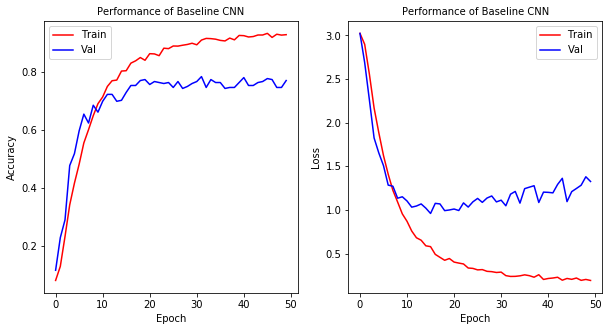

In [26]:
plot_learning(model_1_history, 'Baseline CNN')

### 3.2 Modified CNN

In [172]:
model_2 = Sequential()

model_2.add(Conv2D(32, 3, 1, input_shape=INPUT_SHAPE,activation='relu', name = 'conv2d_1'))
model_2.add(MaxPooling2D(pool_size=(2, 2), name = 'max_pooling2d_1'))
model_2.add(BatchNormalization(name = 'batch_norm_1'))

model_2.add(Conv2D(32, 3, 1, activation='relu', name = 'conv2d_2'))
model_2.add(MaxPooling2D(pool_size=(2, 2), name = 'max_pooling2d_2'))
model_2.add(BatchNormalization(name = 'batch_norm_2'))

model_2.add(Conv2D(64, 3, 1, activation='relu', name = 'conv2d_3'))
model_2.add(MaxPooling2D(pool_size=(2, 2), name = 'max_pooling2d_3'))
model_2.add(Dropout(0.3))

model_2.add(Conv2D(128, 3, 1, activation='relu', name = 'conv2d_4'))
model_2.add(MaxPooling2D(pool_size=(2, 2), name = 'max_pooling2d_4'))

model_2.add(Flatten(name = 'flatten'))  
model_2.add(Dense(500,  activation='relu', name = 'dense_1'))
model_2.add(Dropout(0.3))
model_2.add(Dense(300,  activation='relu', name = 'dense_2'))
model_2.add(Dense(64,  activation='relu', name = 'dense_3'))
model_2.add(Dropout(0.5))
model_2.add(Dropout(0.1))
model_2.add(Dense(OUTPUT_SHAPE, name = 'output'))
model_2.add(Activation('softmax', name='softmax'))


model_2.compile(loss='categorical_crossentropy',optimizer='rmsprop',metrics=['accuracy'])
model_2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 62, 64, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 32, 32)        0         
_________________________________________________________________
batch_norm_1 (BatchNormaliza (None, 31, 32, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 29, 32, 32)        3104      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 16, 32)        0         
_________________________________________________________________
batch_norm_2 (BatchNormaliza (None, 14, 16, 32)        128       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 16, 64)        6208      
__________

In [173]:
model_2_history = model_2.fit(X_train, y_train, batch_size= BATCH_SIZE, 
                              epochs=EPOCHS,validation_data = (X_val, y_val),verbose=1)

Train on 2634 samples, validate on 293 samples
Epoch 1/50
2634/2634 [==============================] - 36s 14ms/step - loss: 3.0278 - acc: 0.0923 - val_loss: 2.9432 - val_acc: 0.1741
Epoch 2/50
2634/2634 [==============================] - 1s 520us/step - loss: 2.8759 - acc: 0.1401 - val_loss: 2.7181 - val_acc: 0.2253
Epoch 3/50
2634/2634 [==============================] - 1s 508us/step - loss: 2.6761 - acc: 0.2043 - val_loss: 2.5251 - val_acc: 0.2969
Epoch 4/50
2634/2634 [==============================] - 1s 511us/step - loss: 2.4853 - acc: 0.2430 - val_loss: 2.3494 - val_acc: 0.3106
Epoch 5/50
2634/2634 [==============================] - 1s 510us/step - loss: 2.2905 - acc: 0.2904 - val_loss: 2.0998 - val_acc: 0.4027
Epoch 6/50
2634/2634 [==============================] - 1s 509us/step - loss: 2.1695 - acc: 0.3193 - val_loss: 1.9725 - val_acc: 0.4164
Epoch 7/50
2634/2634 [==============================] - 1s 509us/step - loss: 2.0385 - acc: 0.3610 - val_loss: 1.8993 - val_acc: 0.4334
E

In [150]:
model_2.save('model_2.h5')

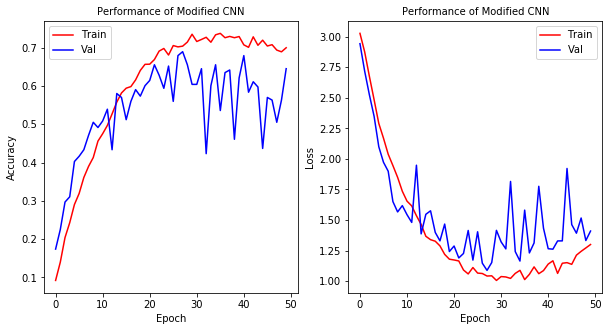

In [174]:
plot_learning(model_2_history, 'Modified CNN')

####  3.2.1 Modified CNN Attacking Methods

In [18]:
model_2 = load_model('model_2.h5')

In [19]:
model_2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 62, 64, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 32, 32)        0         
_________________________________________________________________
batch_norm_1 (BatchNormaliza (None, 31, 32, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 29, 32, 32)        3104      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 16, 32)        0         
_________________________________________________________________
batch_norm_2 (BatchNormaliza (None, 14, 16, 32)        128       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 16, 64)        6208      
__________

##### Method 1: Saliency Maps and Fast Gradient Sign Methods(FGSM)
Using this pretrained model, we will compute class saliency maps as described in Section 3.1 of [2].

A **saliency map** tells us the degree to which each pixel in the image affects the classification score for that image. To compute it, we compute the gradient of the unnormalized score corresponding to the correct class (which is a scalar) with respect to the pixels of the image. If the image has shape `(H, W, 3)` then this gradient will also have shape `(H, W, 3)`; for each pixel in the image, this gradient tells us the amount by which the classification score will change if the pixel changes by a small amount. To compute the saliency map, we take the absolute value of this gradient, then take the maximum value over the 3 input channels; the final saliency map thus has shape `(H, W)` and all entries are nonnegative.

You will need to use the `model.classifier` Tensor containing the scores for each input, and will need to feed in values for the `model.image` and `model.labels` placeholder when evaluating the gradient. Open the file `deeplearning/classifiers/squeezenet.py` and read the documentation to make sure you understand how to use the model. For example usage, you can see the `loss` attribute. 

[2] Karen Simonyan, Andrea Vedaldi, and Andrew Zisserman. "Deep Inside Convolutional Networks: Visualising
Image Classification Models and Saliency Maps", ICLR Workshop 2014.

In [29]:
def compute_saliency_maps(X, y, model):

    outputTensor = model.get_layer('output').output
    correct_scores = tf.gather_nd(outputTensor,
                                      tf.stack((tf.range(X.shape[0]), np.argmax(y, axis=1)), axis=1))
    listOfVariableTensors = model.inputs[0]
    gradients = K.gradients(correct_scores, listOfVariableTensors)
    evaluated_gradients = sess.run(gradients,feed_dict={model.input:X, model.targets[0]:y})[0]
    
    saliency = np.max(np.abs(evaluated_gradients), axis=3)
    
    return saliency

In [ ]:
sample_size = 7
X_sample = X_train[:sample_size]
y_sample = y_train[:sample_size]
saliency = compute_saliency_maps(X_sample, y_sample, model_2)

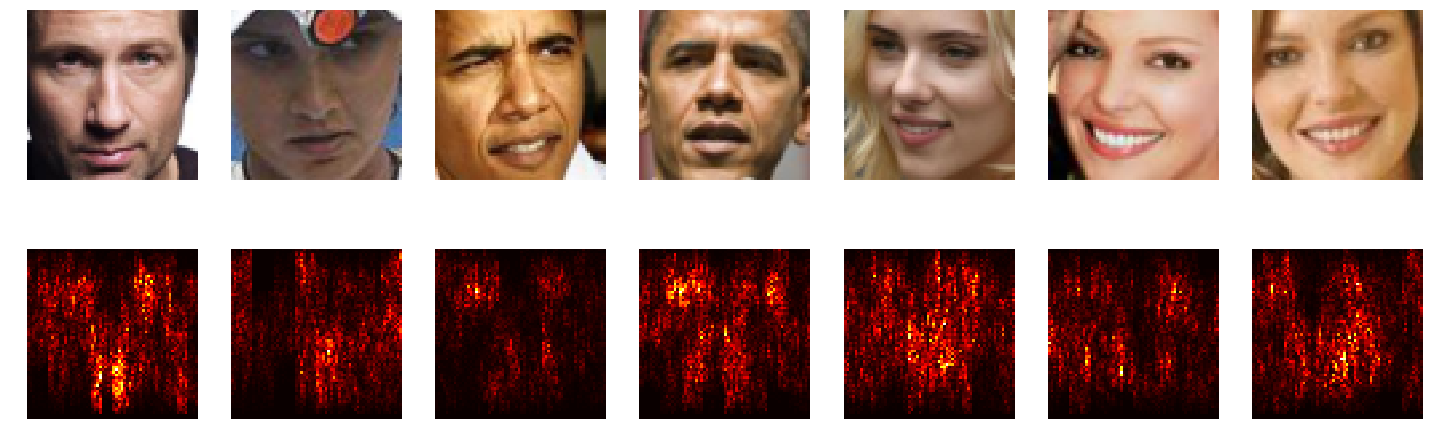

In [25]:
plt.figure(figsize=(20, 7))
for i in range(sample_size):
    plt.subplot(2, sample_size, i + 1)
    plt.imshow(X_sample[i])
    plt.axis('off')
    #plt.title(class_names[ym[i]])
    plt.subplot(2, sample_size, sample_size + i + 1)
    #plt.title(mask[i])
    plt.imshow(saliency[i], cmap=plt.cm.hot)
    plt.axis('off')
    # plt.gcf().set_size_inches(10, 2)
plt.tight_layout()
plt.show()

In [26]:
## https://arxiv.org/pdf/1312.6199.pdf
def FGSM(X, y, model):
    """
    Fast Gradient Sign Method
    Return the fooling image
    """
    X_fooling = X.copy()
    _lambda = 1
    
    label = np.argmax(y, axis=1)[0]
    print("target score: " + str(label))

    values = {model.input:X_fooling, model.targets[0]:y}
    
    outputTensor = model.get_layer('output').output
    
    all_classified_scores = sess.run(outputTensor, feed_dict=values)
    classified_score = np.argmax(all_classified_scores, axis=1)[0]
    print("classified score: " + str(classified_score))
            
    if classified_score != label:
        print("Invalid example because the model makes a wrong prediction")
        return (X_fooling, classified_score)
    
    for t in range(100):
        correct_scores = tf.gather_nd(outputTensor,
                                      tf.stack((tf.range(X_fooling.shape[0]), np.argmax(y, axis=1)), axis=1))
        gradients = K.gradients(correct_scores, model.input)

        dX = sess.run(gradients, feed_dict={model.input:X_fooling})[0]

        
        X_fooling += _lambda * dX / np.linalg.norm(dX)
        X_fooling = np.clip(X_fooling, 0, 1)
                
        all_classified_scores = sess.run(model.output, feed_dict=values)
        classified_score = np.argmax(all_classified_scores, axis=1)[0]
        
        print("t: " + str(t))
        print("classified score: " + str(classified_score))
        print("target score: " + str(label))
    
        if classified_score != label:
            return (X_fooling, classified_score)
        
    return (X_fooling, classified_score)

    

In [27]:
def plot_FGSM(model, i):
    X_single = np.expand_dims(X_train[i], axis=0)
    y_single = np.expand_dims(y_train[i], axis=0)
    X_fooling, classified_score = FGSM(X_single, y_single, model)  

    plt.figure(figsize=(20,10))
    plt.subplot(1, 4, 1)
    plt.imshow(X_single[0])
    plt.axis('off')
    plt.title("true class: " + str(np.argmax(y_single, axis=1)[0]))
    plt.subplot(1, 4, 2)
    plt.imshow(X_fooling[0])
    plt.title("predicted class: " + str(classified_score))
    plt.axis('off')
    plt.subplot(1, 4, 3)
    plt.title('Difference')
    plt.imshow(X_single[0]-X_fooling[0])
    plt.axis('off')
    plt.subplot(1, 4, 4)
    plt.title('Magnified difference (20x)')
    plt.imshow(20 * (X_single[0]-X_fooling[0]))
    plt.axis('off')
    plt.gcf().tight_layout()

target score: 1
classified score: 1


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


t: 0
classified score: 9
target score: 1


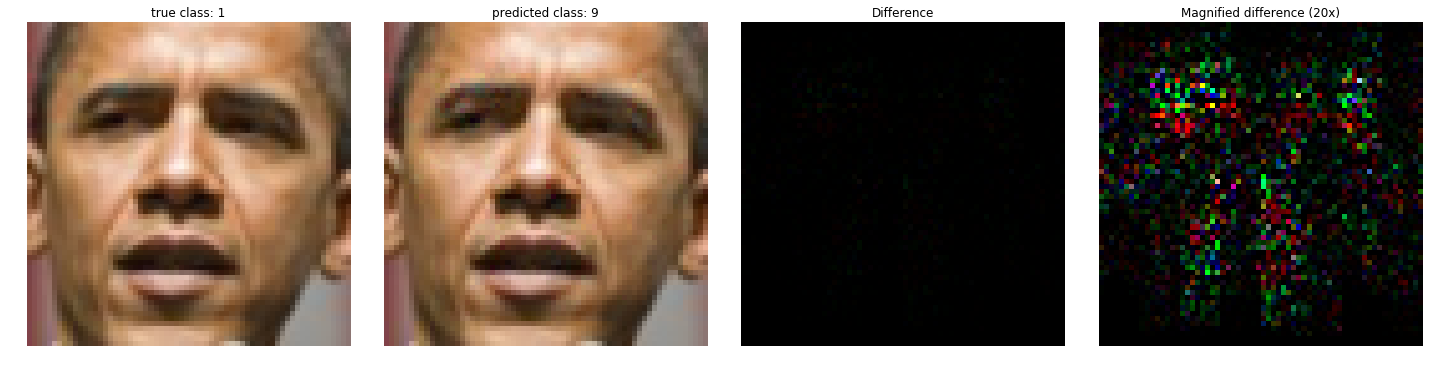

In [28]:
plot_FGSM(model_2, i=3)

#### Method2: Fast Gradient Sign Methods(FGSM) with target

In [72]:
def FGSM_target(X, y_target, model):
    """
    Fast Gradient Sign Method with target.
    Return the fooling image.
    """
    X_fooling = X.copy()
    _lambda = 1
    
    label = np.argmax(y_target, axis=1)[0]
    print("target score: " + str(label))
        
    values = {model.input:X_fooling, model.targets[0]:y_target}
    
    outputTensor = model.get_layer('output').output
    
    all_classified_scores = sess.run(outputTensor, feed_dict=values)
    
    classified_score = np.argmax(all_classified_scores, axis=1)[0]
    print("classified score: " + str(classified_score))
                
    if classified_score == label:
        print("Invalid example because the model makes a wrong prediction")
        return X_fooling
    
    for t in range(100):
        correct_scores = tf.gather_nd(outputTensor,
                                      tf.stack((tf.range(X_fooling.shape[0]), np.argmax(y_target, axis=1)), axis=1))
        gradients = K.gradients(correct_scores, model.input)

        dX = sess.run(gradients, feed_dict={model.input:X_fooling})[0]

        
        X_fooling += _lambda * dX / np.linalg.norm(dX)
        X_fooling = np.clip(X_fooling,0,1)
                
        all_classified_scores = sess.run(model.output, feed_dict=values)
        
        classified_score = np.argmax(all_classified_scores, axis=1)[0]
 
        print("t: " + str(t))
        print("classified score: " + str(classified_score))
        print("target score: " + str(label))
    
        if classified_score == label:
            return X_fooling
        
    return X_fooling

In [73]:
def plot_FGSM_target(model, i, j):
    """
    i : index for the original image
    j : index for the target image
    """
    X_single = np.expand_dims(X_train[i], axis=0)
    y_single = np.expand_dims(y_train[i], axis=0)
    y_single_target = np.expand_dims(y_train[j], axis=0)

    X_fooling = FGSM_target(X_single, y_single_target, model)  

    plt.figure(figsize=(20,10))
    plt.subplot(1, 4, 1)
    plt.imshow(X_single[0])
    plt.axis('off')
    plt.title("true class: " + str(np.argmax(y_single, axis=1)[0]))
    plt.subplot(1, 4, 2)
    plt.imshow(X_fooling[0])
    plt.title("predicted class: " + str(np.argmax(y_single_target, axis=1)[0]))
    plt.axis('off')
    plt.subplot(1, 4, 3)
    plt.title('Difference')
    plt.imshow(X_single[0]-X_fooling[0])
    plt.axis('off')
    plt.subplot(1, 4, 4)
    plt.title('Magnified difference (20x)')
    plt.imshow(20 * (X_single[0]-X_fooling[0]))
    plt.axis('off')
    plt.gcf().tight_layout()

In [80]:
plot_FGSM_target(model_2, i=15, j=16)

target score: 13
classified score: 1
t: 0
classified score: 3
target score: 13
t: 1
classified score: 3
target score: 13
t: 2
classified score: 3
target score: 13
t: 3
classified score: 3
target score: 13
t: 4
classified score: 3
target score: 13
t: 5
classified score: 3
target score: 13
t: 6
classified score: 3
target score: 13
t: 7
classified score: 3
target score: 13
t: 8
classified score: 3
target score: 13
t: 9
classified score: 3
target score: 13


KeyboardInterrupt: 

#### Method3: REEEAL Iterative Fast Gradient Sign Methods(FGSM)

In [193]:
def FGSM(X, y, model):
    """
    Fast Gradient Sign Method
    Return the fooling image
    """
    X_fooling = X.copy()
    eps = 0.02
    
    label = np.argmax(y, axis=1)[0]
    print("ground truth class: " + str(label))

    values = {model.input:X_fooling, model.targets[0]:y}
    
    outputTensor = model.get_layer('output').output
    
    all_classified_scores = sess.run(outputTensor, feed_dict=values)
    classified_score = np.argmax(all_classified_scores, axis=1)[0]
    print("classified class: " + str(classified_score))
    
    if classified_score != label:
        print("Invalid example because the model makes a wrong prediction")
        return (X_fooling, classified_score)
    
    for t in range(100):
#         correct_scores = tf.gather_nd(outputTensor,
#                                       tf.stack((tf.range(X_fooling.shape[0]), np.argmax(y, axis=1)), axis=1))
#         gradients = K.gradients(correct_scores, model.input)
    
        loss = K.categorical_crossentropy(y,outputTensor,from_logits=True)
        gradients = K.gradients(loss, model.input)

        dX = sess.run(gradients, feed_dict={model.input:X_fooling})[0]

        
        X_fooling += eps * np.sign(dX)
        # clipping in the original paper: [X-e,X+e]&[0,1] we don't have hyper-param e here
        X_fooling = np.clip(X_fooling,0,1)
                
        all_classified_scores = sess.run(model.output, feed_dict=values)
        classified_score = np.argmax(all_classified_scores, axis=1)[0]
        
        print("t: " + str(t))
        print("Classified: " + str(classified_score))
        print("Ground truth: " + str(label))
    
        if classified_score != label:
            return (X_fooling, classified_score)
        
    return (X_fooling, classified_score)

In [194]:
def plot_FGSM(model, i):
    X_single = np.expand_dims(X_train[i], axis=0)
    y_single = np.expand_dims(y_train[i], axis=0)
    X_fooling, classified_score = FGSM(X_single, y_single, model)  

    plt.figure(figsize=(20,10))
    plt.subplot(1, 4, 1)
    plt.imshow(X_single[0])
    plt.axis('off')
    plt.title("true class: " + label_name_list[np.argmax(y_single, axis=1)[0]])
    plt.subplot(1, 4, 2)
    plt.imshow(X_fooling[0])
    plt.title("predicted class: " + label_name_list[classified_score])
    plt.axis('off')
    plt.subplot(1, 4, 3)
    plt.title('Difference')
    plt.imshow(X_single[0]-X_fooling[0])
    plt.axis('off')
    plt.subplot(1, 4, 4)
    plt.title('Magnified difference (20x)')
    plt.imshow(20 * (X_single[0]-X_fooling[0]))
    plt.axis('off')
    plt.gcf().tight_layout()

ground truth class: 1
classified class: 1


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


t: 0
Classified: 15
Ground truth: 1


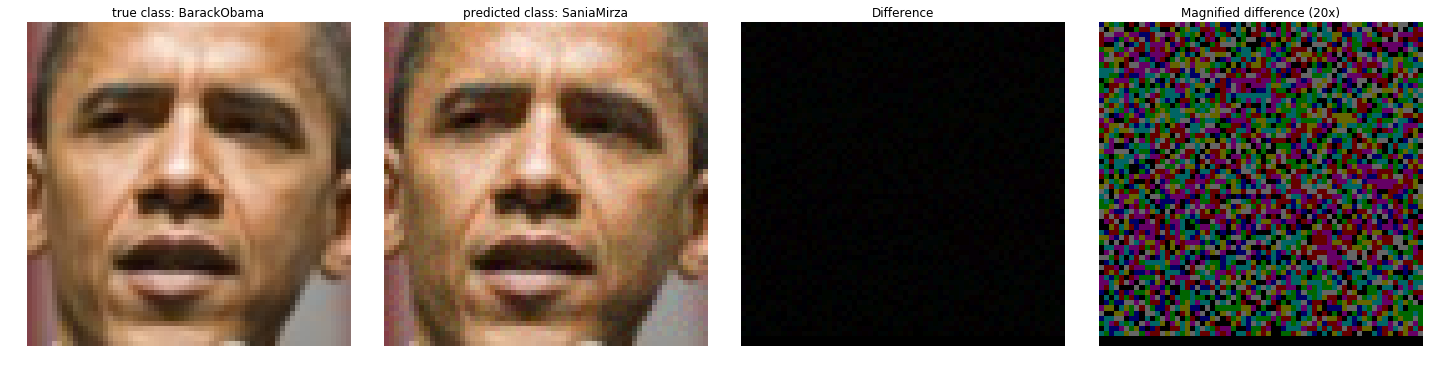

In [195]:
plot_FGSM(model_2, i=3)

In [207]:
def FGSM_target(X, y_target, model):
    """
    Fast Gradient Sign Method with target.
    Return the fooling image.
    """
    X_fooling = X.copy()
    eps = 0.01
    
    label = np.argmax(y_target, axis=1)[0]
    print("target class: " + str(label))
        
    values = {model.input:X_fooling, model.targets[0]:y_target}
    
    outputTensor = model.get_layer('output').output
    
    all_classified_scores = sess.run(outputTensor, feed_dict=values)
    
    classified_score = np.argmax(all_classified_scores, axis=1)[0]
    print("classified class: " + str(classified_score))
                
    if classified_score == label:
        print("Invalid example because the model makes a wrong prediction")
        return X_fooling
    
    for t in range(100):
#         correct_scores = tf.gather_nd(outputTensor,
#                                       tf.stack((tf.range(X_fooling.shape[0]), np.argmax(y_target, axis=1)), axis=1))
#         gradients = K.gradients(correct_scores, model.input)
    
        loss = K.categorical_crossentropy(y_target,outputTensor,from_logits=True)
        gradients = K.gradients(loss, model.input)
        
        dX = sess.run(gradients, feed_dict={model.input:X_fooling})[0]

        
        X_fooling -= eps * np.sign(dX)
        X_fooling = np.clip(X_fooling,0,1)    
        
        all_classified_scores = sess.run(model.output, feed_dict=values)
        
        classified_score = np.argmax(all_classified_scores, axis=1)[0]
 
        print("t: " + str(t))
        print("classified class: " + str(classified_score))
        print("target class: " + str(label))
    
        if classified_score == label:
            return X_fooling
        
    return X_fooling

In [208]:
def plot_FGSM_target(model, i, j):
    """
    i : index for the original image
    j : index for the target image
    """
    X_single = np.expand_dims(X_train[i], axis=0)
    y_single = np.expand_dims(y_train[i], axis=0)
    y_single_target = np.expand_dims(y_train[j], axis=0)

    X_fooling = FGSM_target(X_single, y_single_target, model)  

    plt.figure(figsize=(20,10))
    plt.subplot(1, 4, 1)
    plt.imshow(X_single[0])
    plt.axis('off')
    plt.title("true class: " + str(np.argmax(y_single, axis=1)[0]))
    plt.subplot(1, 4, 2)
    plt.imshow(X_fooling[0])
    plt.title("predicted class: " + str(np.argmax(y_single_target, axis=1)[0]))
    plt.axis('off')
    plt.subplot(1, 4, 3)
    plt.title('Difference')
    plt.imshow(X_single[0]-X_fooling[0])
    plt.axis('off')
    plt.subplot(1, 4, 4)
    plt.title('Magnified difference (20x)')
    plt.imshow(20 * (X_single[0]-X_fooling[0]))
    plt.axis('off')
    plt.gcf().tight_layout()

target class: 19
classified class: 7


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


t: 0
classified class: 19
target class: 19


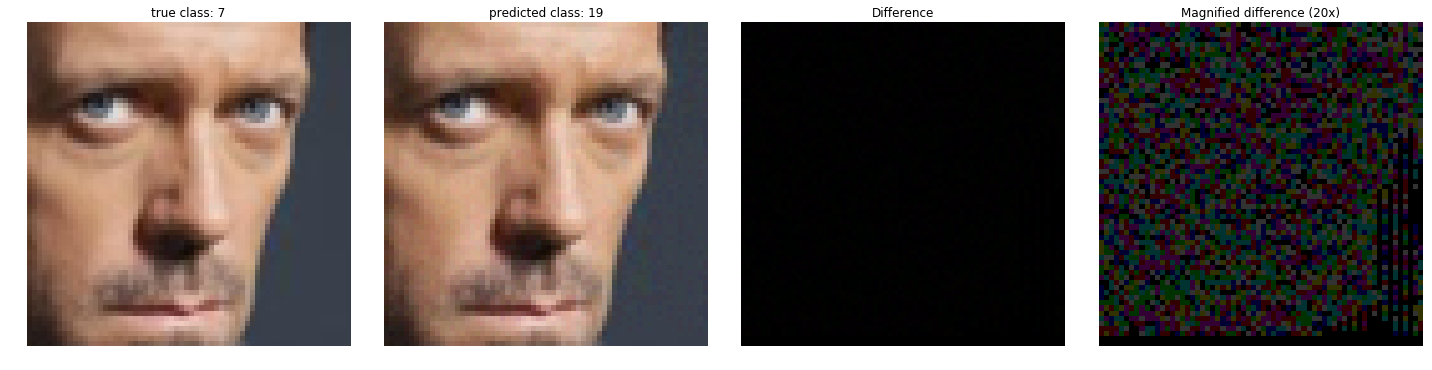

In [209]:
plot_FGSM_target(model_2, i=7, j=84)

In [ ]:
# for generating adversarial images large-scale, consider limit to <10 iterations
# hyperparams to tune: iterations, eps

### 3.3 AlexNet

AlexNet was introduced in 2012 and won Image Classification Challenge. We almost follow the structure and implementation from the original paper: https://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf

In [119]:
model_alex = Sequential()

model_alex.add(Conv2D(96, 11, 4, input_shape=INPUT_SHAPE, border_mode='same', activation='relu'))
model_alex.add(MaxPooling2D(pool_size=(2, 2), strides = (2,2)))
model_alex.add(BatchNormalization())
#model_alex.add(ZeroPadding2D((2, 2)))

model_alex.add(Conv2D(256 ,11 ,1, border_mode='same', activation='relu'))
model_alex.add(MaxPooling2D(pool_size=(2, 2), strides = (2,2)))
model_alex.add(BatchNormalization())
#model_alex.add(ZeroPadding2D((1, 1)))    

model_alex.add(Conv2D(384 ,3 ,3, border_mode='same', activation='relu'))
#model_alex.add(ZeroPadding2D(padding=(1, 1))) 

model_alex.add(Conv2D(192 ,3 ,3, border_mode='same', activation='relu'))
#model_alex.add(ZeroPadding2D(padding=(1, 1))) 

model_alex.add(Conv2D(128 ,3 ,3, activation='relu'))
#model_alex.add(Activation('relu', name='actv_5'))
model_alex.add(MaxPooling2D(pool_size=(3, 3), strides = (2,2)))

model_alex.add(Flatten())  
model_alex.add(Dense(4096, activation='relu'))
model_alex.add(Dropout(0.5))

model_alex.add(Dense(4096, activation='relu'))
model_alex.add(Dropout(0.5))

model_alex.add(Dense(OUTPUT_SHAPE))
model_alex.add(Activation('softmax'))
model_alex.compile(loss='categorical_crossentropy',optimizer='rmsprop',metrics=['accuracy'])
model_alex.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 64, 64, 96)        12768     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 32, 32, 96)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 96)        384       
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 32, 32, 256)       270592    
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 16, 16, 256)       0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 16, 16, 256)       1024      
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 16, 16, 384)       885120    
__________

In [120]:
model_alex_history = model_alex.fit(X_train, y_train, batch_size= BATCH_SIZE, 
                                    epochs=EPOCHS,validation_data = (X_val, y_val),verbose=1)

Train on 3319 samples, validate on 369 samples
Epoch 1/50
3319/3319 [==============================] - 22s 7ms/step - loss: 15.3792 - acc: 0.0419 - val_loss: 15.5939 - val_acc: 0.0325
Epoch 2/50
3319/3319 [==============================] - 15s 4ms/step - loss: 15.4236 - acc: 0.0431 - val_loss: 15.5939 - val_acc: 0.0325
Epoch 3/50
3319/3319 [==============================] - 15s 4ms/step - loss: 15.4236 - acc: 0.0431 - val_loss: 15.5939 - val_acc: 0.0325
Epoch 4/50
3319/3319 [==============================] - 15s 4ms/step - loss: 15.4236 - acc: 0.0431 - val_loss: 15.5939 - val_acc: 0.0325
Epoch 5/50
3319/3319 [==============================] - 15s 4ms/step - loss: 15.4236 - acc: 0.0431 - val_loss: 15.5939 - val_acc: 0.0325
Epoch 6/50
 976/3319 [=======>......................] - ETA: 10s - loss: 15.5731 - acc: 0.0338

KeyboardInterrupt: 

In [ ]:
model_alex.save('model_alex.h5')

### 3.4 GoogleNet (Inception V3)

### 3.5 ResNet

### 3.6 VGG-16

In [117]:
vgg = Sequential()
vgg.add(ZeroPadding2D((1,1),input_shape=INPUT_SHAPE))
vgg.add(Convolution2D(64, 3, 3, activation='relu'))
vgg.add(ZeroPadding2D((1,1)))
vgg.add(Convolution2D(64, 3, 3, activation='relu'))
vgg.add(MaxPooling2D((2,2), strides=(2,2)))

vgg.add(ZeroPadding2D((1,1)))
vgg.add(Convolution2D(128, 3, 3, activation='relu'))
vgg.add(ZeroPadding2D((1,1)))
vgg.add(Convolution2D(128, 3, 3, activation='relu'))
vgg.add(MaxPooling2D((2,2), strides=(2,2)))

vgg.add(ZeroPadding2D((1,1)))
vgg.add(Convolution2D(256, 3, 3, activation='relu'))
vgg.add(ZeroPadding2D((1,1)))
vgg.add(Convolution2D(256, 3, 3, activation='relu'))
vgg.add(ZeroPadding2D((1,1)))
vgg.add(Convolution2D(256, 3, 3, activation='relu'))
vgg.add(MaxPooling2D((2,2), strides=(2,2)))

vgg.add(ZeroPadding2D((1,1)))
vgg.add(Convolution2D(512, 3, 3, activation='relu'))
vgg.add(ZeroPadding2D((1,1)))
vgg.add(Convolution2D(512, 3, 3, activation='relu'))
vgg.add(ZeroPadding2D((1,1)))
vgg.add(Convolution2D(512, 3, 3, activation='relu'))
vgg.add(MaxPooling2D((2,2), strides=(2,2)))

vgg.add(ZeroPadding2D((1,1)))
vgg.add(Convolution2D(512, 3, 3, activation='relu'))
vgg.add(ZeroPadding2D((1,1)))
vgg.add(Convolution2D(512, 3, 3, activation='relu'))
vgg.add(ZeroPadding2D((1,1)))
vgg.add(Convolution2D(512, 3, 3, activation='relu'))
vgg.add(MaxPooling2D((2,2), strides=(2,2)))

vgg.add(Flatten())
vgg.add(Dense(4096, activation='relu'))
vgg.add(Dropout(0.5))
vgg.add(Dense(4096, activation='relu'))
vgg.add(Dropout(0.5))
vgg.add(Dense(OUTPUT_SHAPE, name = 'output'))
vgg.add(Activation('softmax', name='softmax'))

vgg.compile(loss='categorical_crossentropy',optimizer='rmsprop',metrics=['accuracy'])

vgg.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d_5 (ZeroPaddin (None, 66, 66, 3)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 64, 64, 64)        1792      
_________________________________________________________________
zero_padding2d_6 (ZeroPaddin (None, 66, 66, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 64, 64, 64)        36928     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
zero_padding2d_7 (ZeroPaddin (None, 34, 34, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 32, 32, 128)       73856     
__________

In [118]:
vgg_history = vgg.fit(X_train, y_train, batch_size= BATCH_SIZE, 
                              epochs=EPOCHS,validation_data = (X_val, y_val),verbose=1)

Train on 3319 samples, validate on 369 samples
Epoch 1/50
3319/3319 [==============================] - 30s 9ms/step - loss: 15.0224 - acc: 0.0645 - val_loss: 15.2008 - val_acc: 0.0569
Epoch 2/50
3319/3319 [==============================] - 22s 7ms/step - loss: 15.1226 - acc: 0.0618 - val_loss: 15.2008 - val_acc: 0.0569
Epoch 3/50
 896/3319 [=======>......................] - ETA: 15s - loss: 15.2007 - acc: 0.0569

KeyboardInterrupt: 

### 3.4 Model Comparison